In [ ]:
import sys

PWD = '../..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample, plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats

In [ ]:
dataset = np.load(PWD + f'/data/dataset.npz', allow_pickle=True)

In [ ]:
all_X, all_y = dataset['X'], dataset['y']

all_X.shape, all_y.shape

((19570, 64), (19570,))

# Preprocess

In [ ]:
n_baseline = 20

In [ ]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = all_X, all_X, all_y, all_y # to see the same plots as in prepare_dataset

# Utils

In [ ]:
def plot_samples(X, y, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')
        
def plot_difference_hist(y_true, y_pred, channel, hist_range=(-2, 2), n_bins=100):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=True)

    plt.title(f'Diff histogram (channel={channel}), mean={mu:0.3f}, std={std:0.3f}')
    plt.show()
    return std
    
def train_model(model, lr=0.001, name='model', train=True, n_epochs=1000, verbose=1, batch_size=2048, lr_patience=None, es_patience=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr))

    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=f'model_weights/nn_experiments/{name}/weights', save_best_only=True, save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
    
    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(f'model_weights/nn_experiments/{name}/loss_log.csv')

    model.load_weights(f'model_weights/nn_experiments/{name}/weights')
    history = pd.read_csv(f'model_weights/nn_experiments/{name}/loss_log.csv')
    
    return history

# CFD

In [ ]:
cfd = CFD(fraction=0.23)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))
    
y_pred = np.array(y_pred)
y_pred.shape

(3914,)

In [ ]:
mean_squared_error(y_test, y_pred)

1.133668860542164

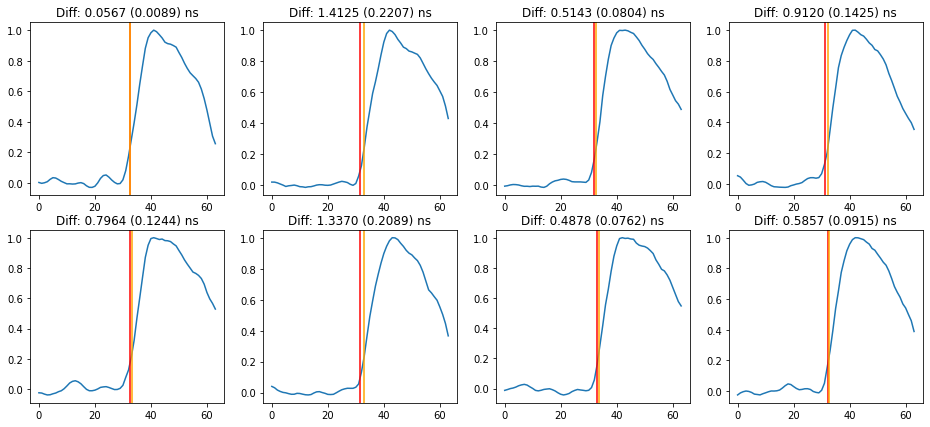

In [ ]:
plt.figure(figsize=(16, 7))
plot_samples(X_test, y_test, y_pred)

In [ ]:
y_pred.shape

(3914,)

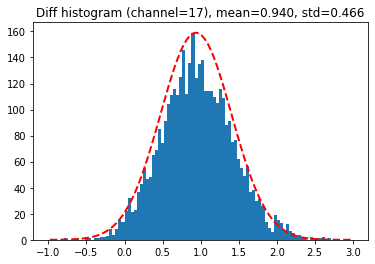

In [ ]:
std_cfd = plot_difference_hist(y_test, y_pred, 17, hist_range=(-1, 3))

# Model 1

In [ ]:
model = keras.Sequential([
    layers.Input(64),
    layers.Dense(1)
])

history = train_model(model, lr=0.1, name='model_1', train=False, n_epochs=3000, lr_patience=50, es_patience=200)

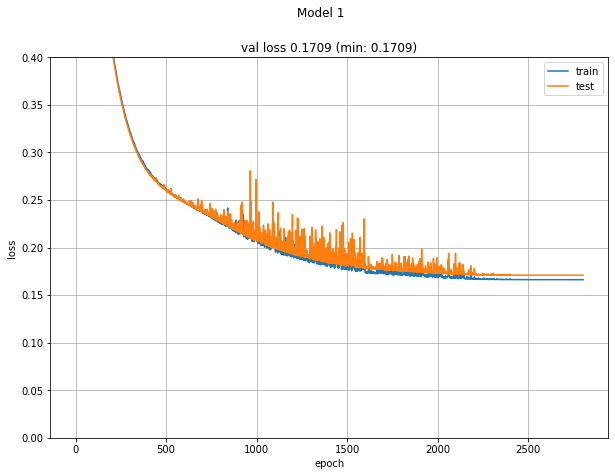

In [ ]:
plot_history(history, "Model 1", ymax=0.4)

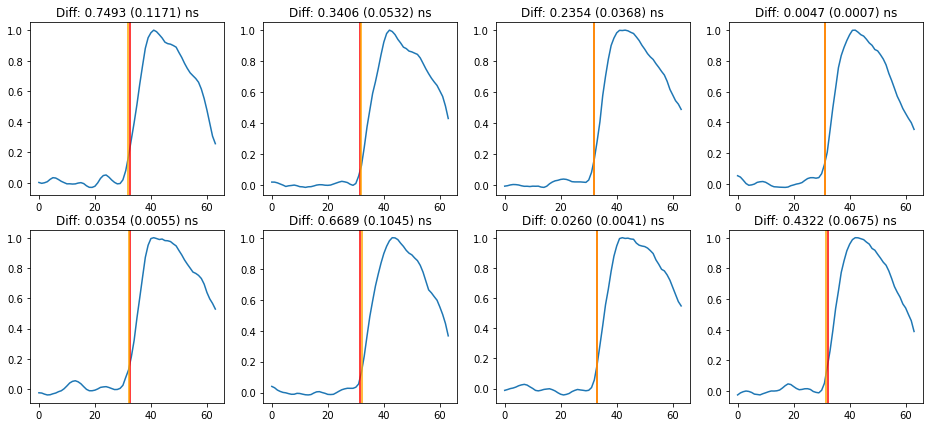

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

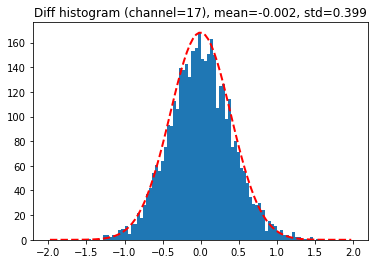

In [ ]:
std_1 = plot_difference_hist(y_test, y_pred, 17)

# Model 2

In [ ]:
model = keras.Sequential([
    layers.Input(64),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

history = train_model(model, lr=0.01, name='model_2', train=False, n_epochs=3000, lr_patience=50, es_patience=200)

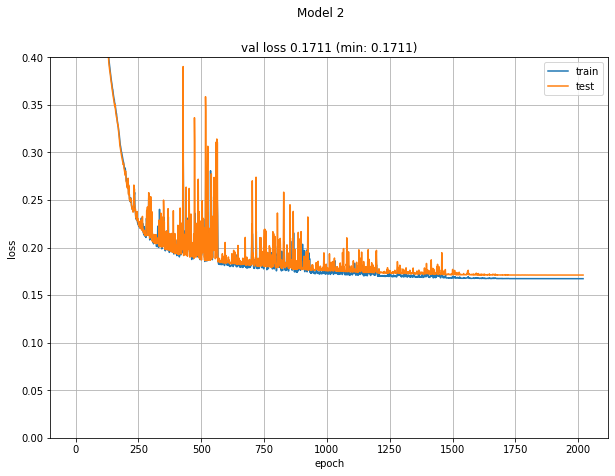

In [ ]:
plot_history(history, "Model 2", ymax=0.4)

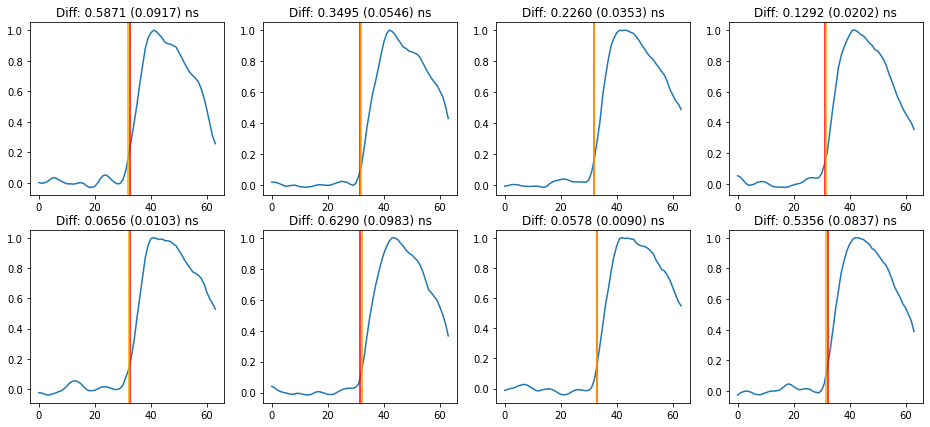

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

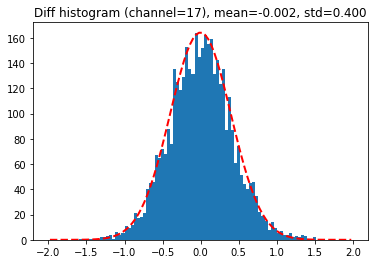

In [ ]:
std_2 = plot_difference_hist(y_test, y_pred, 17)

# Model 3

In [ ]:
model = keras.Sequential([
    layers.Input(64),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

history = train_model(model, lr=0.01, name='model_3', train=False, n_epochs=10000, lr_patience=50, es_patience=1000)

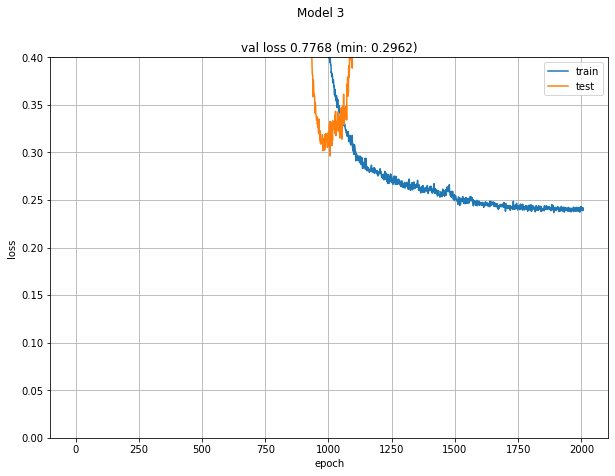

In [ ]:
plot_history(history, "Model 3", ymax=0.4)

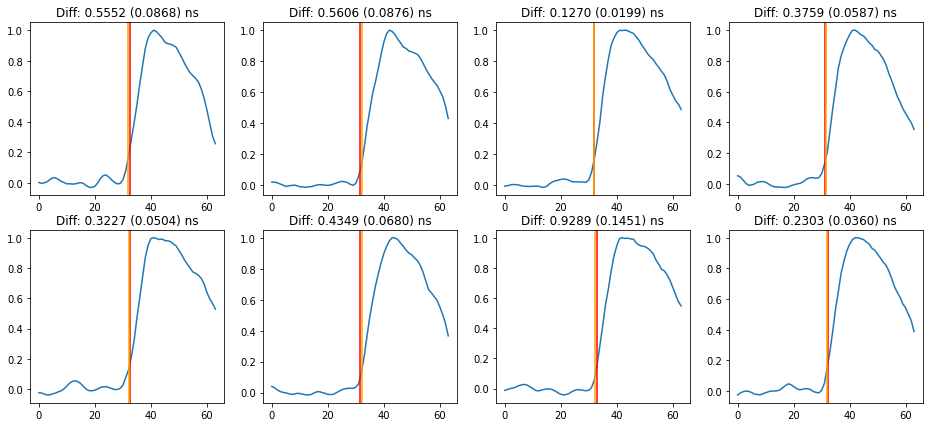

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

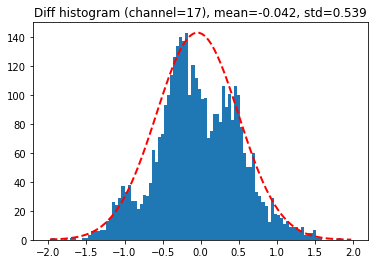

In [ ]:
std_3 = plot_difference_hist(y_test, y_pred, 17)

# Model 4

In [ ]:
model = keras.Sequential([
    layers.Input(64),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, lr=0.1, name='model_4', train=False, n_epochs=3000, lr_patience=50, es_patience=200)

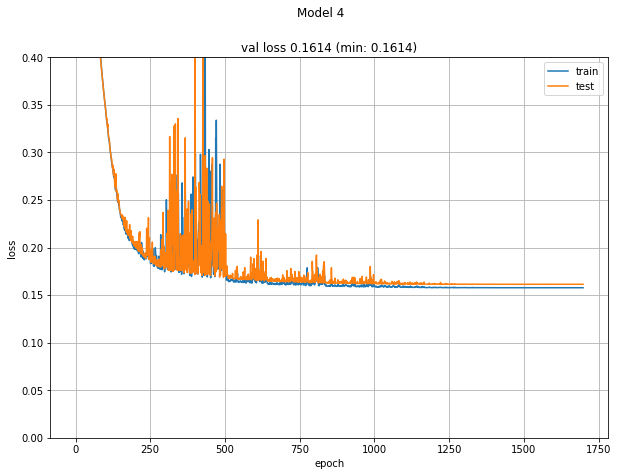

In [ ]:
plot_history(history, "Model 4", ymax=0.4)

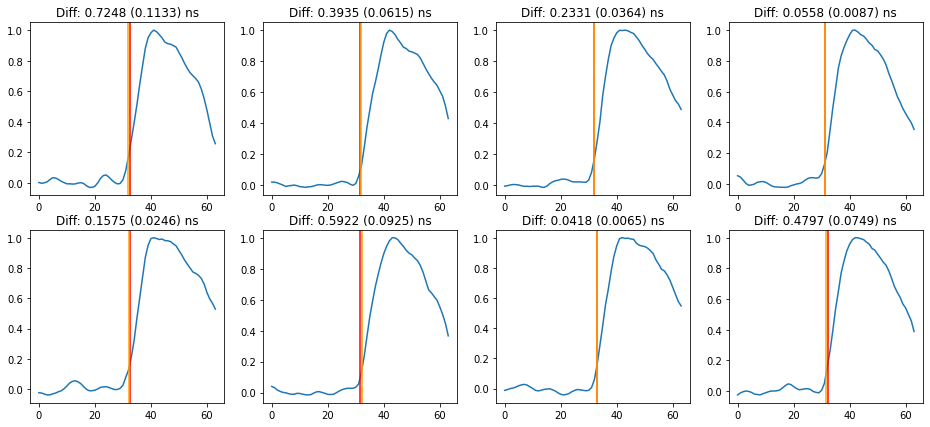

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

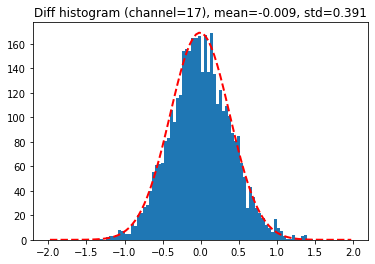

In [ ]:
std_4 = plot_difference_hist(y_test, y_pred, 17)

# Model 5

In [ ]:
model = keras.Sequential([
    layers.Input(64),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, lr=0.001, name='model_5', train=False, n_epochs=3000, lr_patience=100, es_patience=500)

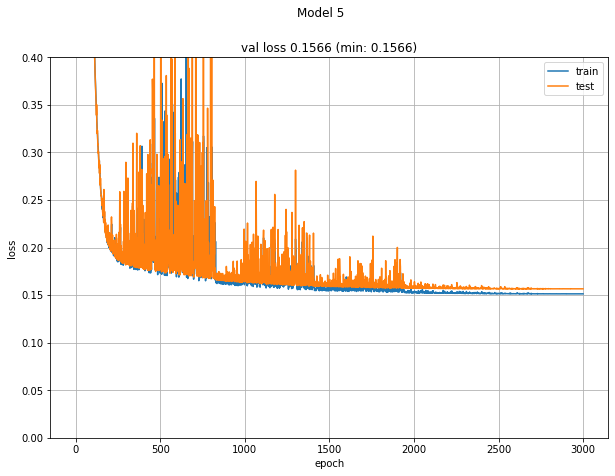

In [ ]:
plot_history(history, "Model 5", ymax=0.4)

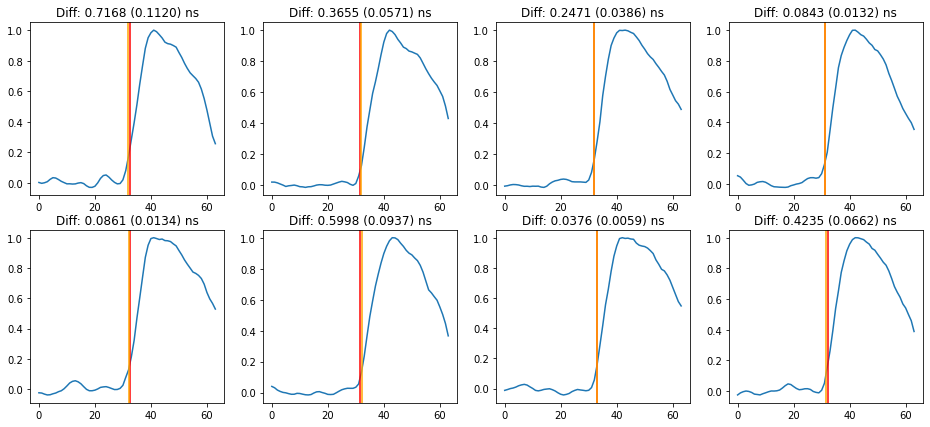

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

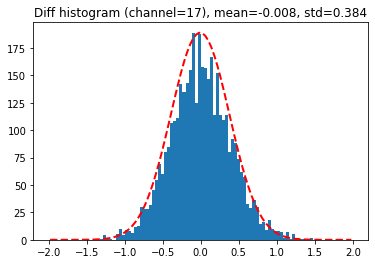

In [ ]:
std_5 = plot_difference_hist(y_test, y_pred, 17)

# Model 6

In [ ]:
def residual_block(x, n_filters):
    skip = layers.Conv1D(n_filters, 1, strides=2)(x)
    
    x = layers.Conv1D(n_filters // 4, 1, strides=2)(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters // 4, 3, padding='same')(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters, 1)(x)
    
    x = layers.Add()([skip, x])
    x = layers.ReLU()(x)
    
    return x

inputs = layers.Input(64)
x = layers.Reshape((-1, 1))(inputs)

x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)

# x = layers.Flatten()(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, lr=0.001, name='model_6', train=False, n_epochs=5000, lr_patience=100, es_patience=400)

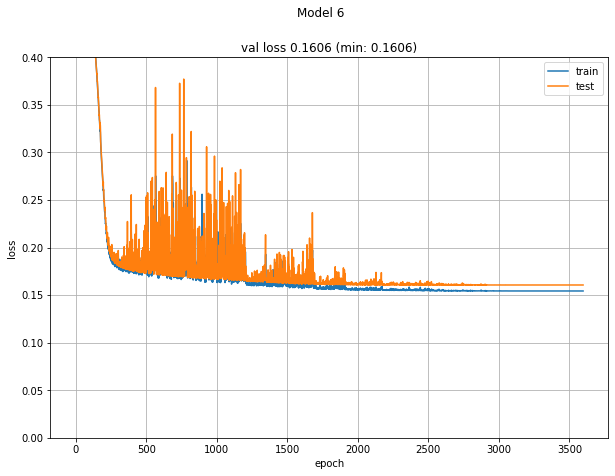

In [ ]:
plot_history(history, "Model 6", ymax=0.4)

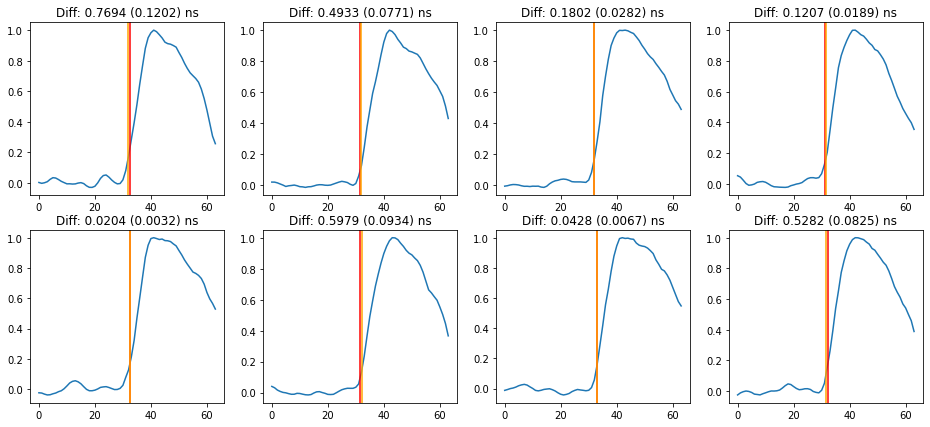

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

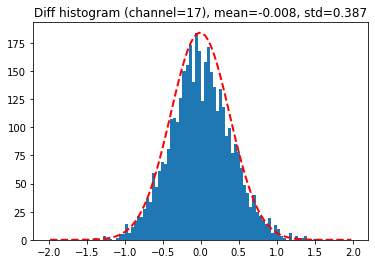

In [ ]:
std_6 = plot_difference_hist(y_test, y_pred, 17)

# Compare standard deviations

In [ ]:
print(f"{'CFD':>10}: {std_cfd:0.4f}")
for i, std in enumerate([std_1, std_2, std_3, std_4, std_5, std_6]):
    print(f"{f'model_{i+1}':>10}: {std:0.4f}")

       CFD: 0.4663
   model_1: 0.3987
   model_2: 0.3995
   model_3: 0.5389
   model_4: 0.3905
   model_5: 0.3839
   model_6: 0.3872
